In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path

In [2]:
def build_model():
    model = Sequential([
        Dense(1024, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(1),
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [3]:
df_missing = pd.read_csv('../Data/df_transformed.csv')
df_missing.drop('Unnamed: 0',axis=1,inplace=True)
df_imputed = pd.read_csv('../Data/dfi_transformed.csv')
df_imputed.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
Models = {}
model_numbers = []
models_file = Path("../Data/nnmodels.csv")
if models_file.is_file():
    models = pd.read_csv(models_file)
    models.drop('Unnamed: 0',axis=1,inplace=True)
    model_numbers = list(models.number)
    for key in models.columns:
        Models[key] = list(models[key])

In [5]:
def model(number,return_model=False, return_xy=False):
    global Models,df_missing,df_imputed
    info = {}
    info['number']=number
    
    imputed = False
    num_variables=['RIDAGEYR','BPXPLS','Systolic','Diastolic']
    cat_variables =['RIAGENDR','RIDRETH3']
    info['imputed']=1
    if number % 2 == 0: # use imputed values (remember to drop na before train test split)
        df = df_missing
        info['imputed']=0
    else:
        df = df_imputed
        imputed = True
        cat_variables.extend(['BPXPLS_i','Systolic_i','Diastolic_i'])
    number = (number - number%2)//2
    info['drop outliers']=0
    if number%2==1: # drop outliers
        info['drop outliers']=1
        df = df[df.outlier==0].copy()
    number = (number - number%2)//2
    info['limit y range']=0
    if number % 2 == 1: # reduce y range
        info['limit y range']=1
        number -= 1
        df = df[(df.LBXTC>=100)&(df.LBXTC<400)].copy()
    number = number//2
    info['bmi only']=1
    if number % 2 == 1: # use height and weight
        info['bmi only']=0
        number = number - 1
        num_variables.extend([ 'BMXWT', 'BMXHT'])
        if imputed:
            cat_variables.extend(['BMXWT_i', 'BMXHT_i'])
    else:
        num_variables.append('BMXBMI')
        if imputed:
            cat_variables.append('BMXBMI_i')
    number = number//2
    info['include pulse irregularity']=0
    if number%2==1: # include irregular pulse
        info['include pulse irregularity']=1
        number -= 1
        cat_variables.append('BPXPULS')
        if imputed:
            cat_variables.append('BPXPULS_i')
    number = number//2
    info['include chronic conditions']=0
    if number % 2 == 1: # include chronic conditions
        number -= 1
        info['include chronic conditions']=1
        cat_variables.extend(['BPQ020', 'BPQ050A', 'BPQ080','BPQ100D', 'DIQ010', 'MCQ170M'])
        if imputed:
            cat_variables.extend(['BPQ020_i', 'BPQ050A_i', 'BPQ080_i', 'BPQ100D_i', 'DIQ010_i','MCQ170M_i'])
    number = number//2
    info['use transformed physical activity']=0
    if number % 2 == 1: # use transformed physical activity
        number -= 1
        info['use transformed physical activity']=1
        num_variables.append('MET_rec')
        if imputed:
            cat_variables.append('MET_rec_i')
    else:
        num_variables.extend(['PAQ655','PAD660','PAQ670','PAD675'])
        if imputed:
            cat_variables.extend(['PAQ655_i','PAD660_i','PAQ670_i','PAD675_i'])
    number = number // 2
    info['include nutrients']=0
    info['nutrient variable type']=np.nan
    if number%2 == 0: # don't include nutrients
        number = (number - number%6)//6
    else:
        info['include nutrients']=1
        number = (number-1)//2
        if number % 3 == 0: # include original nutrients
            num_variables.extend(['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA'])
            cat_variables.append('DR1_300')
            if imputed:
                cat_variables.append('DR1_300_i')
            info['nutrient variable type']='original'
        elif number % 3 == 1: # include transformed nutrients
            info['nutrient variable type']='transformed'
            num_variables.extend(['DR1TKCAL_t',
       'DR1TPROT_t', 'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t',
       'DR1TSFAT_t', 'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t',
       'DR1TVD_t', 'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t'])
            if imputed:
                cat_variables.append('DR1_300_i')
        else: # include both
            info['nutrient variable type']='both'
            num_variables.extend(['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA','DR1TKCAL_t',
       'DR1TPROT_t', 'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t',
       'DR1TSFAT_t', 'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t',
       'DR1TVD_t', 'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t'])
            if imputed:
                cat_variables.append('DR1_300_i')
        number = (number - number%3)//3
    info['include alcohol and tobacco']=0
    info['alcohol variable type']=np.nan
    if number % 2 == 0: # don't include alcohol and tobacco
        number = (number - number % 6)//6
    else: # include alcohol and tobacco
        number = (number - 1)//2
        # add tobacco here
        cat_variables.append('SMQ681')
        info['include alcohol and tobacco']=1
        if imputed:
            cat_variables.append('SMQ681_i')
        if number % 3 == 0: # include original alcohol quantities
            info['alcohol variable type']='original'
            
            num_variables.extend([ 'ALQ120Q','ALQ130'])
            cat_variables.append('ALQ120U')
            if imputed:
                cat_variables.extend(['ALQ120Q_i', 'ALQ120U_i', 'ALQ130_i'])
        elif number % 3 == 1: # include transformed alcohol quantities
            info['alcohol variable type']='transformed'
            num_variables.append('avgALC')
            if imputed:
                cat_variables.append('avgALC_i')
        else: # include both
            info['alcohol variable type']='both'
            num_variables.extend([ 'ALQ120Q','ALQ130','avgALC'])
            cat_variables.append('ALQ120U')
            if imputed:
                cat_variables.extend(['ALQ120Q_i', 'ALQ120U_i', 'ALQ130_i','avgALC_i'])
        number = (number-number%3)//3
    df = df[num_variables+cat_variables+['LBXTC','log_LBXTC']].copy()
    df.dropna(inplace=True)
    y = df.LBXTC
    info['log transform y']=0
    if number % 2 == 1: # use log transformed y
        info['log transform y']=1
        number -= 1
        y = df.log_LBXTC
    number = number//2
    X = df[num_variables+cat_variables].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)
    numeric_transformer = Pipeline(steps=[('scalar',MinMaxScaler())])
    cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])
    info['Winsorize x']=0
    if number % 2 == 1: # Winsorize x
        info['Winsorize x']=1
        numeric_transformer.steps.insert(0,('winsorizor',Winsorizer()))
        number -= 1
    number = number//2
    info['log transform numeric variables']=0
    if number % 2 == 1: # log transform x
        info['log transform numeric variables']=1
        number -= 1
        numeric_transformer.steps.insert(0,('log transform x',FunctionTransformer(np.log1p)))
    number = number // 2
    preprocessor = ColumnTransformer(transformers=[
        ('num',numeric_transformer,num_variables),
        ('cat',cat_transformer,cat_variables)])
    nn = Pipeline(steps=[('preprocessor',preprocessor),
                          ('mlp', KerasRegressor(build_fn=build_model, epochs=25, batch_size=5, verbose=0))])
    info['include PCA']=0
    if number % 2 == 1: # add PCA
        nn.steps.insert(1,("pca",PCA(0.95)))
        info['include PCA']=1

    nn.fit(X_train,y_train)

    #may need to adjust this
    y_train_preds = nn.predict(X_train)
    r2 = r2_score(y_train,y_train_preds)
    info['r2']=r2
    k = X_train.shape[1]
    if 'pca' in nn.named_steps:
        k = len(nn.named_steps['pca'].components_)
    n = X_train.shape[0]
    if r2 < 0:
        ar2 = 0
    else:
        ar2 = 1-(1-r2)*(n-1)/(n-k-1)
    info['adjusted r2']=ar2
    
    y_preds = nn.predict(X_test)
    info['training MAE'] = mean_absolute_error(y_train,y_train_preds)
    info['testing MAE'] = mean_absolute_error(y_test,y_preds)
    info['training RMSE'] = mean_squared_error(y_train,y_train_preds,squared=False)
    info['testing RMSE'] = mean_squared_error(y_test,y_preds,squared=False)
    info['MAE percent difference'] = (info['testing MAE']-info['training MAE'])/info['training MAE']
    info['RMSE percent difference'] = (info['testing RMSE']-info['training RMSE'])/info['training RMSE']
    if return_model:
        if return_xy:
            return (nn, X_train, X_test, y_train, y_train_preds,y_test,y_preds)
        return (nn, info)
    for key in info.keys():
        if key not in Models:
            Models[key]=[]
        Models[key].append(info[key])

In [6]:
for i in range(10):
    n = np.random.randint(73728)
    while n in model_numbers:
        n = np.random.randint(73728)
    model_numbers.append(n)
    model(n)


In [7]:
models = pd.DataFrame(Models)
top_10 = models.sort_values(by=['adjusted r2','RMSE percent difference'],ascending=[False,True]).head(10)
top_10

,number,imputed,drop outliers,limit y range,bmi only,include pulse irregularity,include chronic conditions,use transformed physical activity,include nutrients,nutrient variable type,...,log transform numeric variables,include PCA,r2,adjusted r2,training MAE,testing MAE,training RMSE,testing RMSE,MAE percent difference,RMSE percent difference
1,61345,1,0,0,1,0,1,0,1,both,...,1,1,0.326394,0.322013,0.196710,0.199893,0.252350,0.259577,0.016178,0.028638
2,41600,0,0,0,1,0,0,0,1,original,...,0,1,0.320867,0.318601,0.200350,0.202628,0.254585,0.255462,0.011367,0.003445
17,47315,1,1,0,1,1,0,1,1,transformed,...,0,1,0.085776,0.080813,31.056324,33.070335,40.127513,42.797289,0.064850,0.066532
22,57576,0,0,0,0,0,1,1,1,both,...,1,1,0.061607,0.057102,31.706383,33.700037,40.920231,42.571812,0.062879,0.040361
41,48014,0,1,1,0,0,0,0,1,transformed,...,0,1,0.056632,0.051859,30.855872,32.831860,38.914634,41.153726,0.064039,0.057539
24,21022,0,1,1,0,1,0,0,0,NaN,...,1,0,0.053526,0.048538,30.603025,30.925282,38.827101,39.942314,0.010530,0.028723
39,57703,1,1,1,1,0,1,1,0,NaN,...,1,1,0.041292,0.036844,31.000455,30.675101,39.481005,38.847593,-0.010495,-0.016043
38,57728,0,0,0,1,0,0,0,1,original,...,1,1,0.040973,0.035948,31.508399,32.752304,40.807206,43.518196,0.039479,0.066434
0,48018,0,1,0,1,1,0,0,1,transformed,...,0,1,0.014872,0.009920,32.590798,34.304728,42.136337,43.395224,0.052589,0.029877
12,38960,0,0,0,1,1,1,0,0,NaN,...,0,1,0.012095,0.008208,32.301438,33.352045,41.910615,42.651124,0.032525,0.017669


In [8]:
top_10.transpose(copy=True)

,1,2,17,22,41,24,39,38,0,12
number,61345,41600,47315,57576,48014,21022,57703,57728,48018,38960
imputed,1,0,1,0,0,0,1,0,0,0
drop outliers,0,0,1,0,1,1,1,0,1,0
limit y range,0,0,0,0,1,1,1,0,0,0
bmi only,1,1,1,0,0,0,1,1,1,1
include pulse irregularity,0,0,1,0,0,1,0,0,1,1
include chronic conditions,1,0,0,1,0,0,1,0,0,1
use transformed physical activity,0,0,1,1,0,0,1,0,0,0
include nutrients,1,1,1,1,1,0,0,1,1,0
nutrient variable type,both,original,transformed,both,transformed,NaN,NaN,original,transformed,NaN


In [9]:
network, X_train, X_test, y_train, y_train_preds,y_test,y_preds = model(61345, return_model=True, return_xy=True)

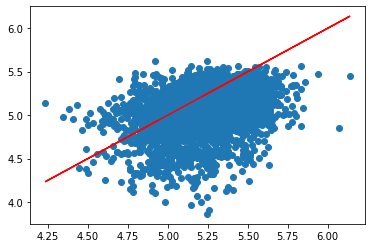

In [10]:
plt.scatter(y_train, y_train_preds)
plt.plot(y_train, y_train, color="red")

In [11]:
models.to_csv("../Data/nnmodels.csv")